In [50]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import matplotlib.patheffects as path_effects
from highlight_text import fig_text, ax_text
from dotenv import load_dotenv
import os

# load functions
from functions.feature_engineering import *
from functions.plot_functions import BboxLocator, draw_table_image
from functions.spotify_api import SpotifyAPI

In [51]:
# set some colors
spotify_green = "#1DB954"
spotify_black = "#191414"

In [52]:
# read in data
artists, tracks = get_data(
    audio_path="../../data/spotify_audio_features.json",
    artists_path="../../data/spotify_artists.json",
    playlists_path="../../data/spotify_top_50_playlists.json",
)

In [53]:
# pick some markets
markets = {
    "usa": "United States",
    "japan": "Japan",
    "nigeria": "Nigeria",
    "argentina": "Argentina",
}

In [54]:
# function look at distribution of audio features
def plot_audio_feature_distr(fig, axs, tracks, markets, audio_feature, scale_by_100=True, zero_100_axis=True):
    for i, market in enumerate(markets):
        market_data = tracks[tracks["market_id"] == market]

        axs[i].grid(axis="y", alpha=0.2)
        if scale_by_100:
            axs[i].hist(
                market_data[audio_feature] * 100,
                rwidth=1,
                edgecolor=spotify_black,
                color=spotify_green,
                linewidth=2.5,
            )
        else:
            axs[i].hist(
                market_data[audio_feature],
                rwidth=1,
                edgecolor=spotify_black,
                color=spotify_green,
                linewidth=2.5,
            )

        # remove all underscores from audio_feature and make title case
        audio_feature_title = audio_feature.replace("_", " ").title()

        # make audio feature title case
        axs[i].set_xlabel(audio_feature_title + " Rating")
        axs[i].set_ylabel("# of Tracks")
        axs[i].set_title(
            f"Distribution of {audio_feature_title} Ratings - {markets[market]}", fontweight="bold", fontsize=9
        )
        if zero_100_axis:
            axs[i].set_xticks(range(0, 101, 10))
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["bottom"].set_visible(False)
        axs[i].spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

### Energy Plot


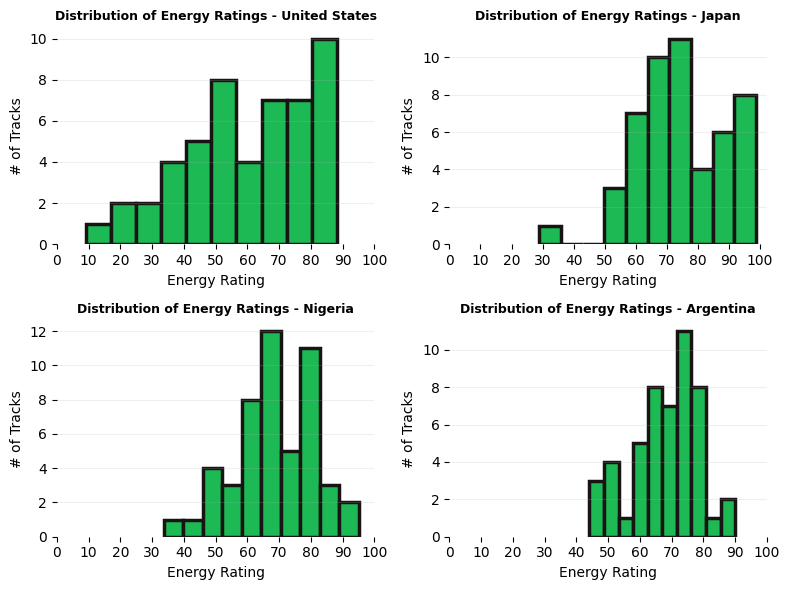

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()
plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="energy",
)

### Acousticness Plot


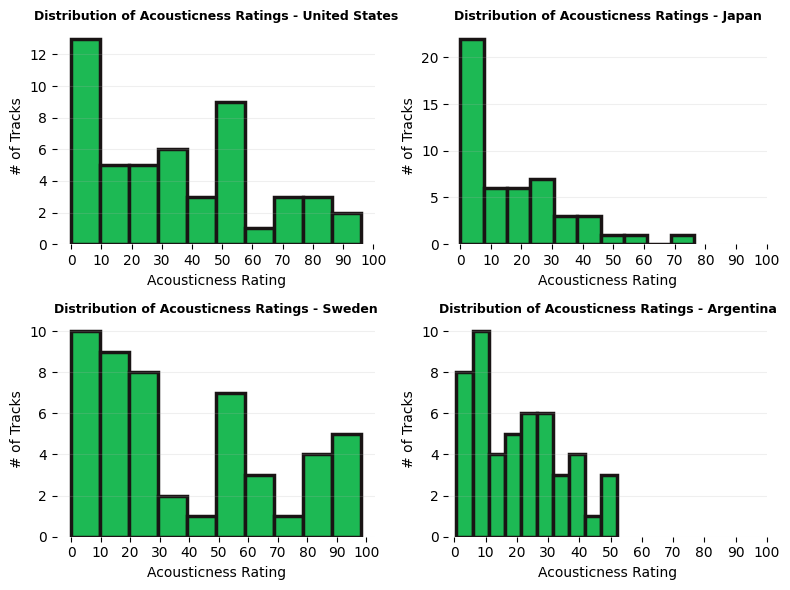

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()

markets = {
    "usa": "United States",
    "japan": "Japan",
    "sweden": "Sweden",
    "argentina": "Argentina",
}

plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="acousticness",
)

### Valence Plot


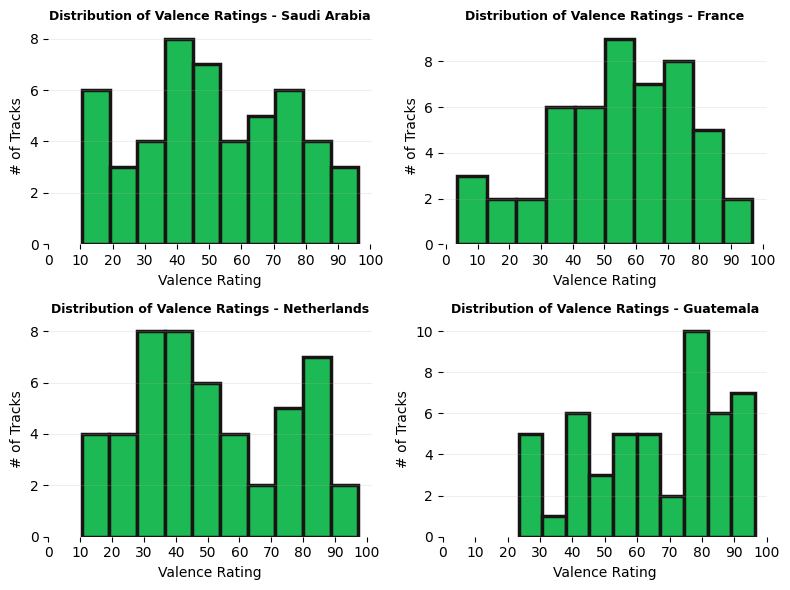

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()

markets = {
    "saudi_arabia": "Saudi Arabia",
    "france": "France",
    "netherlands": "Netherlands",
    "guatemala": "Guatemala",
}

plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="valence",
)

### Scatter Plot


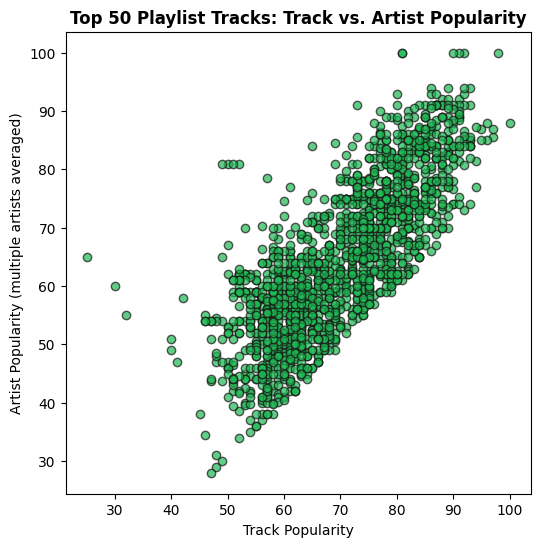

In [58]:
# distinct tracks
distinct_tracks = tracks.drop_duplicates(subset=["track_id"])

plt.figure(figsize=(6, 6))

# scatter plot of popularity and avg_artist_popularity
plt.scatter(
    x=distinct_tracks["track_popularity"],
    y=distinct_tracks["avg_artist_popularity"],
    color=spotify_green,
    edgecolors=spotify_black,
    alpha=0.7,
)

plt.xlabel("Track Popularity")
plt.ylabel("Artist Popularity (multiple artists averaged)")
plt.title("Top 50 Playlist Tracks: Track vs. Artist Popularity", fontweight="bold")

plt.show()

### Outliers Table


In [59]:
# filter for single artists
single_artists = distinct_tracks[distinct_tracks["num_artists"] == 1].copy()

# difference column
single_artists["pop_diff"] = single_artists["track_popularity"] - single_artists["avg_artist_popularity"]
# extract id from artist_ids object
single_artists["artist_id"] = single_artists["artist_ids"].apply(lambda x: x[0]["id"])

# select columns
single_artists = single_artists[["track_name", "track_popularity", "pop_diff", "artist_id"]]

# join artist info
single_artists = pd.merge(single_artists, artists[["artist_id", "artist_name"]], on="artist_id", how="left")

# take top 10 in absolute value pop_diff
single_artists["abs_pop_diff"] = single_artists["pop_diff"].abs()

# sort by abs_pop_diff
single_artists.sort_values(by="abs_pop_diff", ascending=False, inplace=True)

# take top 10
top_10_pop_diff = single_artists.head(10)

# de-select artist_id and abs_pop_diff
top_10_pop_diff = top_10_pop_diff[["artist_name", "track_name", "track_popularity", "pop_diff", "artist_id"]]

In [60]:
# we'll use the spotify api to get the artist images

# read in secrets
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# init api
spotify = SpotifyAPI(client_id=client_id, client_secret=client_secret)

# init all artist images
all_artist_images = list()

for artist_id in top_10_pop_diff["artist_id"].unique():
    artist_images = spotify.request_artist(artist_id=artist_id, img_only=True)
    # append to all artist images
    all_artist_images.append(artist_images)

# turn into a dataframe
all_artist_images = pd.DataFrame(all_artist_images)

-- retrieved artist: Anuv Jain --
-- retrieved artist: Burna Boy --
-- retrieved artist: ODUMODUBLVCK --
-- retrieved artist: Suspekt --
-- retrieved artist: Iera Milpan --
-- retrieved artist: BENNETT --
-- retrieved artist: Mehdi Fadili --


In [61]:
# join back
top_10_pop_diff = pd.merge(top_10_pop_diff, all_artist_images, on="artist_id", how="left")
# select final columns
table_dat = top_10_pop_diff[["artist_img", "artist_name", "track_name", "track_popularity", "pop_diff"]]

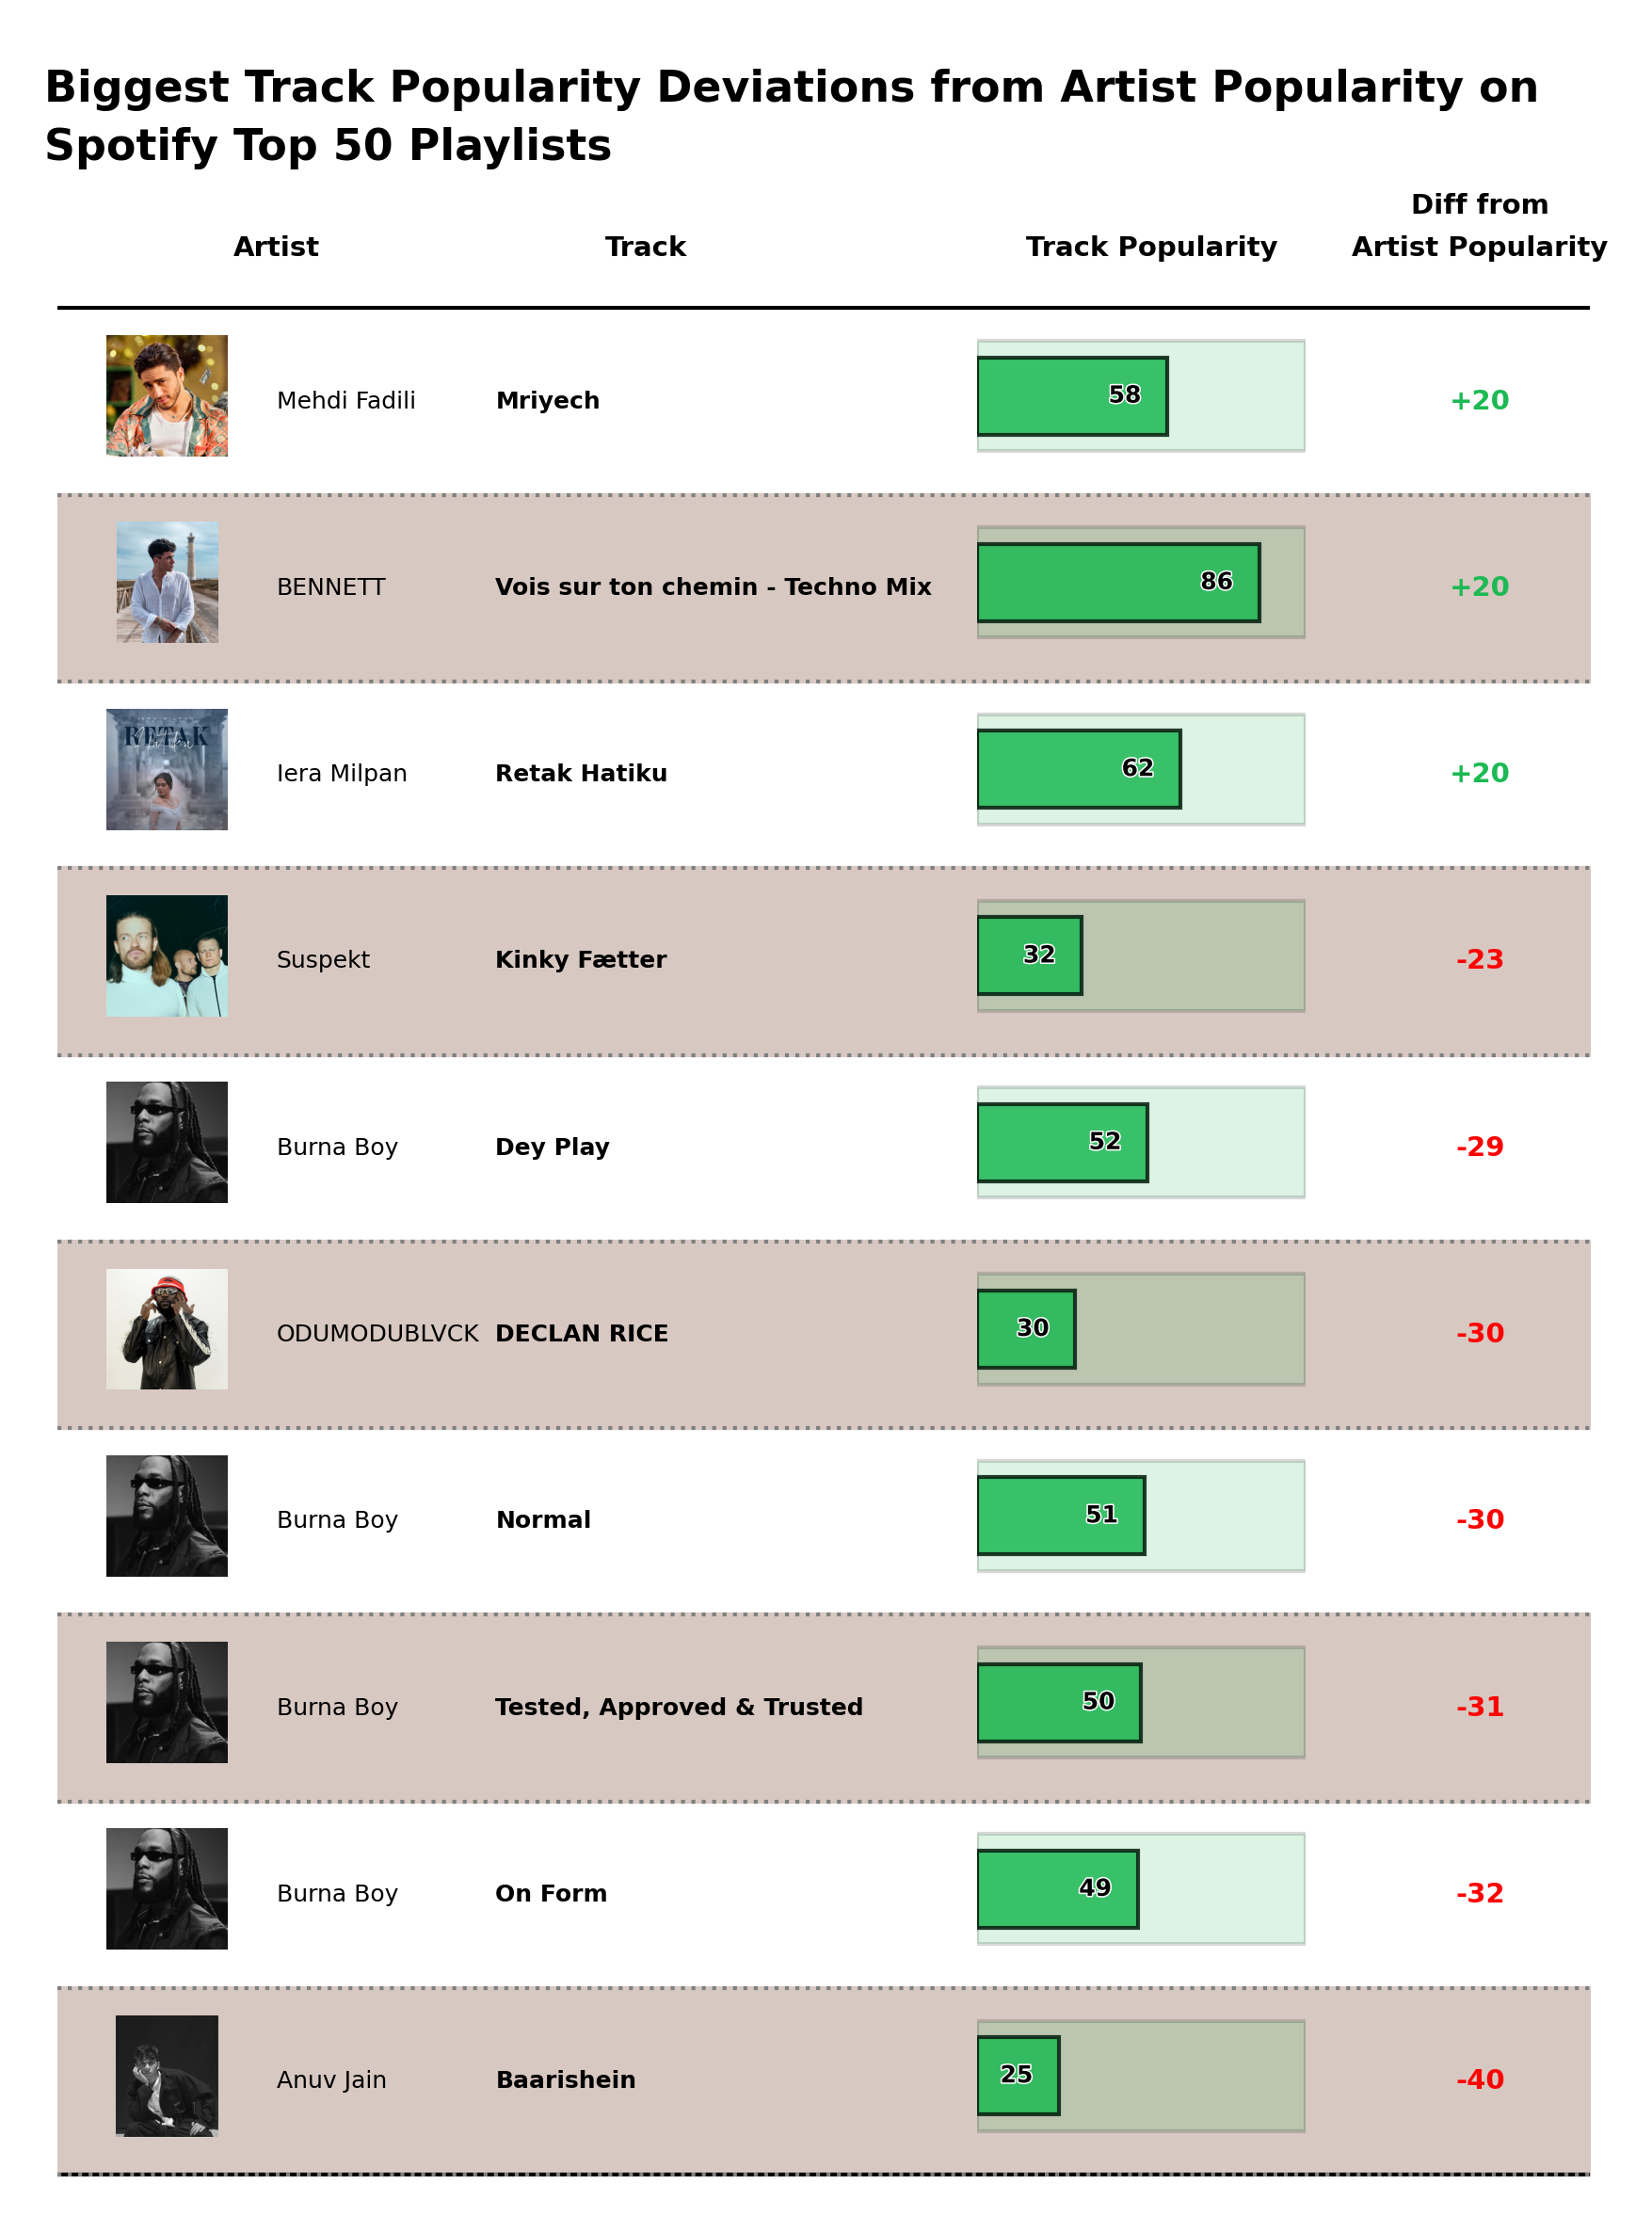

In [64]:
fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.subplot()

nrows = table_dat.shape[0]
ncols = table_dat.shape[1]

ax.set_xlim(0, ncols + 2)
ax.set_ylim(-0.65, nrows + 1)

# calculate asymmetry of x and y axes
x0, y0 = ax.transAxes.transform((0, 0))  # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1))  # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = 1.5 * maxd / dx
height = 0.85 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Artist image
    bbox = Bbox.from_bounds(0, y - 0.295, 1, 0.65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_table_image(table_dat["artist_img"].iloc[y], logo_ax)

    # -- Artist name
    ax_text(x=1, y=y, s=table_dat["artist_name"].iloc[y], size=6, ha="left", va="center", ax=ax)

    # -- Track name
    ax_text(x=2, y=y, s=table_dat["track_name"].iloc[y], size=6, ha="left", va="center", ax=ax, weight="bold")

    # -- Track popularity
    bbox = Bbox.from_bounds(4.2, y - 0.295, 1.5, 0.65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0, 100)
    battery_ax.barh(
        y=0.5, width=table_dat["track_popularity"].iloc[y], height=0.35, alpha=0.85, color=spotify_green, ec="black"
    )
    battery_ax.barh(y=0.5, width=100, height=0.5, alpha=0.15, color=spotify_green, ec="black")
    text_ = battery_ax.annotate(
        xy=(table_dat["track_popularity"].iloc[y], 0.5),
        xytext=(-15, 0),
        textcoords="offset points",
        text=f"{table_dat['track_popularity'].iloc[y]}",
        ha="left",
        va="center",
        size=6,
        weight="bold",
    )
    text_.set_path_effects([path_effects.Stroke(linewidth=0.75, foreground="white"), path_effects.Normal()])
    battery_ax.set_axis_off()

    # -- Popularity difference
    # if pop_diff > 0, color green, else color red
    if table_dat["pop_diff"].iloc[y] > 0:
        color = spotify_green
        text = "+" + str(int(table_dat["pop_diff"].iloc[y]))
    else:
        color = "#FF0000"
        text = str(int(table_dat["pop_diff"].iloc[y]))

    ax_text(x=6.5, y=y, s=text, size=7, ha="center", va="center", ax=ax, weight="bold", color=color)

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - 0.5, nrows - 0.5], lw=1, color="black", zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-0.5, -0.5], lw=1, color="black", zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x - 0.5, y2=x + 0.5, color="#d7c8c1", zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - 0.5, x - 0.5], lw=1, color="grey", ls=":", zorder=3)

ax.set_axis_off()

# -- Column titles
ax_text(
    x=5,
    y=nrows - 0.25,
    s="Track Popularity",
    size=7,
    ha="center",
    va="bottom",
    ax=ax,
    textalign="center",
    weight="bold",
)
ax_text(
    x=6.5,
    y=nrows - 0.25,
    s="Diff from\nArtist Popularity",
    size=7,
    ha="center",
    va="bottom",
    ax=ax,
    textalign="center",
    weight="bold",
)
ax_text(x=1, y=nrows - 0.25, s="Artist", size=7, ha="center", va="bottom", ax=ax, textalign="left", weight="bold")
ax_text(x=2.5, y=nrows - 0.25, s="Track", size=7, ha="left", va="bottom", ax=ax, textalign="left", weight="bold")

fig_text(
    x=0.5,
    y=0.83,
    s="Biggest Track Popularity Deviations from Artist Popularity on \nSpotify Top 50 Playlists",
    va="bottom",
    ha="center",
    fontsize=11,
    color="black",
    weight="bold",
)

plt.savefig(
    "../../figures/track_popularity_deviation.png",
    dpi=600,
    facecolor="#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent=False,
)